**Normalization / scaling**

In [37]:
import pandas as pd, numpy as np, pathlib, os, joblib, matplotlib.pyplot as plt

TARGET = "Default"  # ← change if your label column has a different name

OUT = pathlib.Path("results/outputs"); OUT.mkdir(parents=True, exist_ok=True)

# pick best-available files
def first_existing(paths):
    for p in paths:
        if p.exists(): return p
    return None

p_train = first_existing([
    OUT/"train_outliers_capped_log.csv",
    OUT/"train_outliers_capped.csv",
    OUT/"train_missing_handled.csv",
    OUT/"train_split.csv",
])
p_val   = first_existing([
    OUT/"val_outliers_capped_log.csv",
    OUT/"val_outliers_capped.csv",
    OUT/"val_missing_handled.csv",
    OUT/"val_split.csv",
])
p_test  = first_existing([
    OUT/"test_outliers_capped_log.csv",
    OUT/"test_outliers_capped.csv",
    OUT/"test_missing_handled.csv",
    OUT/"test_split.csv",
])

assert p_train and p_val and p_test, "Could not find split files. Run earlier steps first."

train = pd.read_csv(p_train)
val   = pd.read_csv(p_val)
test  = pd.read_csv(p_test)
print("Loaded:", p_train.name, p_val.name, p_test.name)

assert TARGET in train.columns, f"{TARGET} not found in train."


Loaded: train_outliers_capped.csv val_outliers_capped.csv test_outliers_capped.csv


In [38]:
# separate features/labels
X_train = train.drop(columns=[TARGET]).copy()
y_train = train[TARGET].astype(int).copy()
X_val   = val.drop(columns=[TARGET]).copy()
y_val   = val[TARGET].astype(int).copy()
X_test  = test.drop(columns=[TARGET]).copy()
y_test  = test[TARGET].astype(int).copy()

# identify numeric vs categorical
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

print("Numeric columns to scale:", len(num_cols))
print("Categorical columns untouched:", len(cat_cols))


Numeric columns to scale: 7
Categorical columns untouched: 0


In [39]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()  # mean=0, std=1

X_train_std = X_train.copy()
X_val_std   = X_val.copy()
X_test_std  = X_test.copy()

# fit only on TRAIN numeric columns
X_train_std[num_cols] = std_scaler.fit_transform(X_train[num_cols])
X_val_std[num_cols]   = std_scaler.transform(X_val[num_cols])
X_test_std[num_cols]  = std_scaler.transform(X_test[num_cols])

# quick check: train numeric columns mean≈0, std≈1
means = X_train_std[num_cols].mean().round(3)
stds  = X_train_std[num_cols].std(ddof=0).round(3)
print("TRAIN (after StandardScaler) mean≈0?\n", means.head(8))
print("TRAIN (after StandardScaler) std≈1?\n", stds.head(8))

# save scaler + datasets
joblib.dump(std_scaler, OUT/"scaler_standard.pkl")
train_std = X_train_std.copy(); train_std[TARGET] = y_train.values
val_std   = X_val_std.copy();   val_std[TARGET]   = y_val.values
test_std  = X_test_std.copy();  test_std[TARGET]  = y_test.values

train_std.to_csv(OUT/"train_scaled_standard.csv", index=False)
val_std.to_csv(  OUT/"val_scaled_standard.csv",   index=False)
test_std.to_csv( OUT/"test_scaled_standard.csv",  index=False)
print("Saved StandardScaler outputs to results/outputs/*.csv and scaler_standard.pkl")


TRAIN (after StandardScaler) mean≈0?
 CustomerID      0.0
Age             0.0
AnnualIncome    0.0
LoanAmount      0.0
CreditScore    -0.0
LoanTerm        0.0
ExistingDebt    0.0
dtype: float64
TRAIN (after StandardScaler) std≈1?
 CustomerID      1.0
Age             1.0
AnnualIncome    1.0
LoanAmount      1.0
CreditScore     1.0
LoanTerm        1.0
ExistingDebt    1.0
dtype: float64
Saved StandardScaler outputs to results/outputs/*.csv and scaler_standard.pkl


Visualizing columns: ['CustomerID', 'Age', 'AnnualIncome']


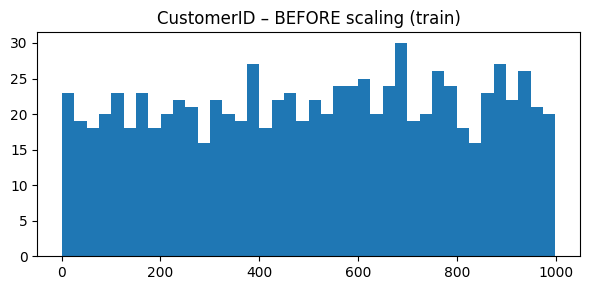

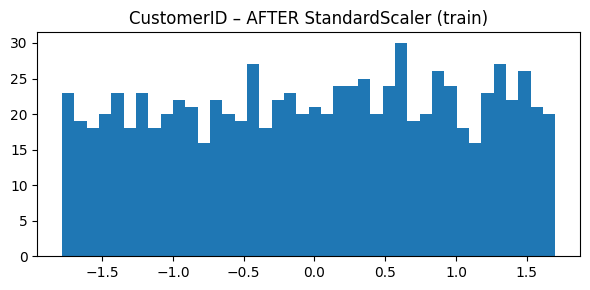

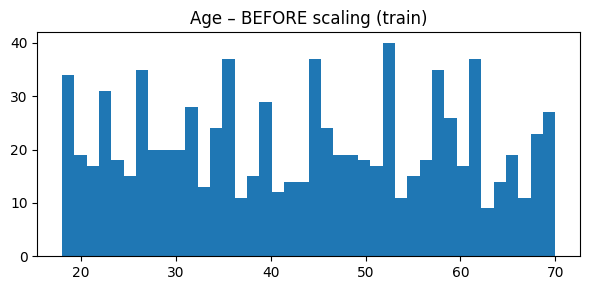

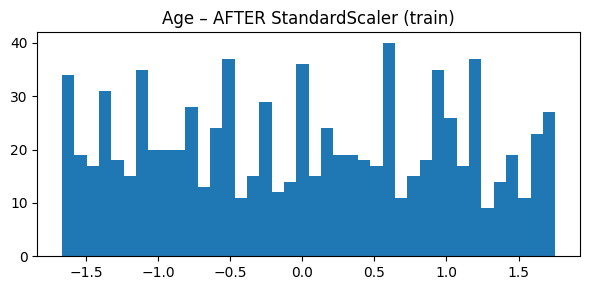

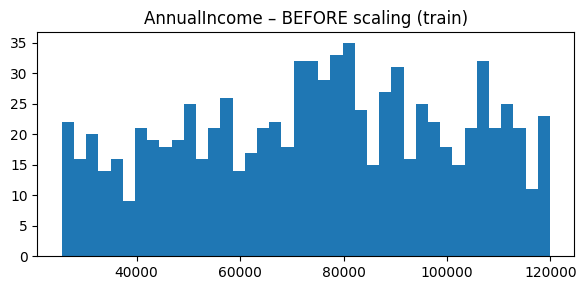

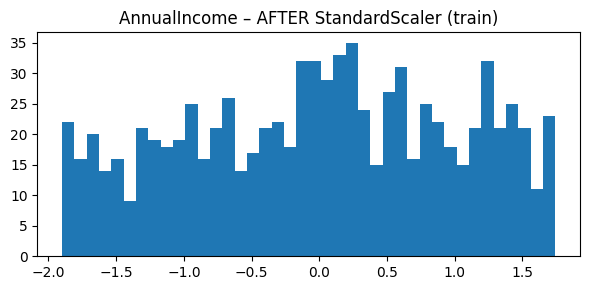

In [40]:
import matplotlib.pyplot as plt

sample_cols = num_cols[:3] if len(num_cols) >= 3 else num_cols
print("Visualizing columns:", sample_cols)

for c in sample_cols:
    # before
    plt.figure(figsize=(6,3))
    plt.hist(X_train[c].dropna(), bins=40)
    plt.title(f"{c} – BEFORE scaling (train)")
    plt.tight_layout(); plt.show()
    # after StandardScaler
    plt.figure(figsize=(6,3))
    plt.hist(X_train_std[c].dropna(), bins=40)
    plt.title(f"{c} – AFTER StandardScaler (train)")
    plt.tight_layout(); plt.show()
